# Dependency code

In [1]:
%run ../lib/cmdbench/bioinformatics/multibench.py

COBS will have to be built directly from source <https://github.com/bingmann/cobs>. Version used is commit `7c030bbb4804b142f4336a1808af1095d9398f4a`.

# Benchmarking

In [2]:
import sys
import os
import shutil
import numpy as np
import glob
import cmdbench

def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
            
def reset_func():
    clean_if_exists("cobs-data/samples/")
    clean_if_exists("cobs-data/example.cobs_compact")
    clean_if_exists("cobs-data/example.cobs_compact.tmp")
            
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }

def create_folder_if_doesnt_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input'

input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
print(input_samples)

['MOD1_LS1005', 'CFSAN000961', 'CFSAN001112', 'CFSAN023467', 'CFSAN001115', 'CFSAN000970', 'MOD1_LS982', 'CFSAN000958', 'D7331', 'CFSAN000960', '2014D-0189', '2014C-3656', 'CFSAN001140', 'MOD1_LS1006', 'CFSAN023470', 'CFSAN023466', 'CFSAN000951', 'D7321', 'MOD1_LS997', 'CFSAN023464', '2014C-3907', 'PNUSA000195', 'CFSAN000752', 'CFSAN023469', 'CFSAN000661', 'CFSAN000191', 'PNUSAL000730', 'CFSAN000212', 'PNUSA000196', 'CFSAN023471', 'CFSAN000669', 'D7323', '2014D-0070', 'MOD1_LS1008', '2014D-0068', 'CFSAN023468', 'D7333', 'D7320', '2014C-3850', 'CFSAN000700', 'D7327', 'D7330', 'D5663', 'CFSAN023465', 'CFSAN000952', '2014C-3857', 'MOD1_LS1000', 'MOD1_LS995', 'CFSAN000189', 'MOD1_LS998', 'CFSAN000954', 'D7329', '2014C-3655', 'MOD1_LS996', 'D7316', 'CFSAN002349', 'MOD1_LS1004', 'MOD1_LS1010', 'MOD1_LS985', '2014D-0067', 'D7322', 'CFSAN000963', 'D7324', 'CFSAN023463', '2014C-3600', '2014C-3599', 'CFSAN000753', 'D7328', 'PNUSAL000870', 'MOD1_LS1011', 'CFSAN000968', 'PNUSAL000957', 'CFSAN00021

In [3]:
create_folder_if_doesnt_exist("cobs-data")
create_folder_if_doesnt_exist("cobs-data/samples")

In [4]:
nproc=4
kmer=31
hashes=3

sample_sizes = [1,10,20,30,40,50,60,70,80,85]

def sampling_func(sample_size):
    # Copy files we want to be part of the sample
    # from inputs to cobs-data/samples/ and return their path
    samples = input_samples[:sample_size]
    samples_out = []
    for sample in samples:
        infile1, infile2 = os.path.abspath(f"{input_dir}/{sample}_1.fastq.gz"), os.path.abspath(f"{input_dir}/{sample}_2.fastq.gz")
        outfile1, outfile2 = f"cobs-data/samples/{sample}_1.fastq.gz", f"cobs-data/samples/{sample}_2.fastq.gz"
        os.symlink(infile1, outfile1)
        os.symlink(infile2, outfile2)
    return ["cobs-data/samples/"]

build_command = {
    "command": f"cobs compact-construct -k {kmer} --threads {nproc} --num-hashes {hashes} cobs-data/samples/ cobs-data/example.cobs_compact",
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": "cobs query -i cobs-data/example.cobs_compact %",
    "parallel_argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": f"-j {nproc} -I%"
}

multibench_results, debug_str = multi_cmdbench({
"index": [build_command],
"query": [query_command]
}, reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results, active_output_print = True)


>>>>>>>>>>>>>
cobs compact-construct -k 31 --threads 4 --num-hashes 3 cobs-data/samples/ cobs-data/example.cobs_compact

STDOUT: --- document list (2 entries) ---
document[0] size 127318059 31-mers 155846621 : cobs-data/samples/MOD1_LS1005_1.fastq.gz : MOD1_LS1005_1
document[1] size 143401396 31-mers 155934637 : cobs-data/samples/MOD1_LS1005_2.fastq.gz : MOD1_LS1005_2
--- end of document list (2 entries) ---
documents: 2
minimum 31-mers: 155846621
maximum 31-mers: 155934637
average 31-mers: 155890629
total 31-mers: 311781258

-------------
STDERR: Parameters:
  input                      (string)            "cobs-data/samples/"
  out_file                   (string)            "cobs-data/example.cobs_compact"
Options:
  -C, --clobber              (bool)              false
      --continue             (bool)              false
  -f, --false-positive-rate  (double)            0.3
      --file-type            (string)            "any"
      --keep-temporary       (bool)              false


# Save and reload results

In [5]:
save_path = "cobs-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

save_multibench_results(multibench_results, samples_per_sample_size, save_path)

In [6]:
multibench_results, samples_per_sample_size = read_multibench_results(save_path)
print(samples_per_sample_size)

[['MOD1_LS1005'], ['MOD1_LS1005,', 'CFSAN000961,', 'CFSAN001112,', 'CFSAN023467,', 'CFSAN001115,', 'CFSAN000970,', 'MOD1_LS982,', 'CFSAN000958,', 'D7331,', 'CFSAN000960'], ['MOD1_LS1005,', 'CFSAN000961,', 'CFSAN001112,', 'CFSAN023467,', 'CFSAN001115,', 'CFSAN000970,', 'MOD1_LS982,', 'CFSAN000958,', 'D7331,', 'CFSAN000960,', '2014D-0189,', '2014C-3656,', 'CFSAN001140,', 'MOD1_LS1006,', 'CFSAN023470,', 'CFSAN023466,', 'CFSAN000951,', 'D7321,', 'MOD1_LS997,', 'CFSAN023464'], ['MOD1_LS1005,', 'CFSAN000961,', 'CFSAN001112,', 'CFSAN023467,', 'CFSAN001115,', 'CFSAN000970,', 'MOD1_LS982,', 'CFSAN000958,', 'D7331,', 'CFSAN000960,', '2014D-0189,', '2014C-3656,', 'CFSAN001140,', 'MOD1_LS1006,', 'CFSAN023470,', 'CFSAN023466,', 'CFSAN000951,', 'D7321,', 'MOD1_LS997,', 'CFSAN023464,', '2014C-3907,', 'PNUSA000195,', 'CFSAN000752,', 'CFSAN023469,', 'CFSAN000661,', 'CFSAN000191,', 'PNUSAL000730,', 'CFSAN000212,', 'PNUSA000196,', 'CFSAN023471'], ['MOD1_LS1005,', 'CFSAN000961,', 'CFSAN001112,', 'CFSAN023

# Plot

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'runtime': 115.87, 'memory': 428175360.0, 'disk_read': 964113584.0, 'disk_write': 3803481008.0}, {'runtime': 490.17, 'memory': 2657583104.0, 'disk_read': 7928409999.0, 'disk_write': 9723144353.0}, {'runtime': 1177.94, 'memory': 5296988160.0, 'disk_read': 16530651987.0, 'disk_write': 13756255257.0}, {'runtime': 1574.28, 'memory': 8471355392.0, 'disk_read': 23539250114.0, 'disk_write': 16930801794.0}, {'runtime': 2321.41, 'memory': 4957405184.0, 'disk_read': 29625047616.0, 'disk_write': 21831676262.0}, {'runtime': 2873.87, 'memory': 5975142400.0, 'disk_read': 40870133222.0, 'disk_write': 24239570538.0}, {'runtime': 3601.0, 'memory': 8362377216.0, 'disk_read': 47952386448.0, 'disk_write': 24658276526.0}, {'runtime': 6182.0, 'memory': 10618744832.0, 'disk_read': 56228933527.0, 'disk_write': 33147985468.0}, {'runtime': 5645.0, 'memory': 9733152768.0, 'disk_read': 60819811800.0, 'disk_write': 30520307475.0}, {'runtime': 6960.0, 'memory': 12118937600.0, 'disk_read': 67410618107.0, 'disk_wri

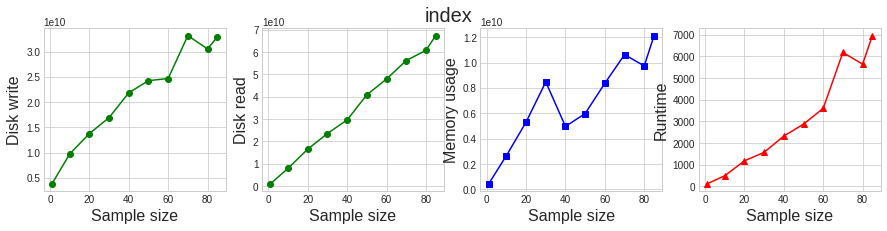

In [8]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'runtime': 0.22, 'memory': 27410432.0, 'disk_read': 1893555.0, 'disk_write': 298373.0}, {'runtime': 0.24, 'memory': 27561984.0, 'disk_read': 1893004.0, 'disk_write': 298341.0}, {'runtime': 0.22, 'memory': 27312128.0, 'disk_read': 1891340.0, 'disk_write': 298325.0}, {'runtime': 0.49, 'memory': 27267072.0, 'disk_read': 1890214.0, 'disk_write': 281988.0}, {'runtime': 0.23, 'memory': 27344896.0, 'disk_read': 1890266.0, 'disk_write': 306700.0}, {'runtime': 1.03, 'memory': 50470912.0, 'disk_read': 1902367.0, 'disk_write': 602592.0}, {'runtime': 1.05, 'memory': 29437952.0, 'disk_read': 1896726.0, 'disk_write': 504069.0}, {'runtime': 1.48, 'memory': 48402432.0, 'disk_read': 1906588.0, 'disk_write': 471949.0}, {'runtime': 1.51, 'memory': 59211776.0, 'disk_read': 1907862.0, 'disk_write': 595058.0}, {'runtime': 1.65, 'memory': 47316992.0, 'disk_read': 1912570.0, 'disk_write': 611882.0}]


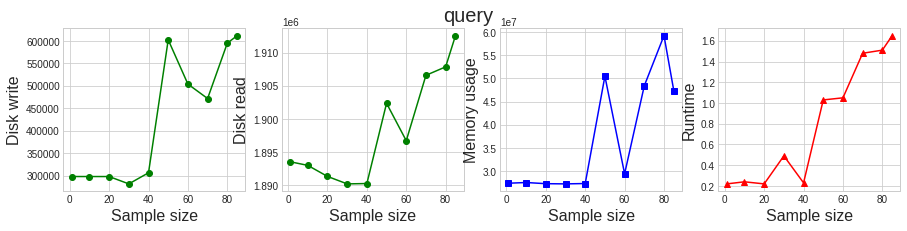

In [9]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")